In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.csv
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.csv
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.csv
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT_numbers_replaced_with_at_sign/train/train.txt
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT/dev.csv
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT/test.txt
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT/dev.txt
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT/train.csv
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT/test.csv
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT/train/train.txt
/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT/dev.csv
/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT/test.txt
/kaggle/input/pubmed-200k-rtc/PubMed_20k_

# Sequential Sentence classification using RNNs.

We here replicating the pub_med_rct_200K research paper, The dataset given is also from that research paper. 
Here we are going to write lots of code and lots of models for experimentation which give best results will be choosen. 

The Paper is : https://arxiv.org/abs/1710.06071

So lets starts 

## 1. Confirm the Access to a GPU

In [2]:
!nvidia-smi

Wed Jan  1 16:53:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. Data Collection(load dataset) 
We will be using 200k dataset with at_sign because numbers in dataset are replaced by @ in dataset.

In [3]:
!ls /kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.csv  dev.txt  test.csv  test.txt  train.csv  train.txt


In [4]:
# Data dir
train_dir='/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.csv'
val_dir='/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.csv'
test_dir='/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.csv'

In [5]:
import pandas as pd

train_df=pd.read_csv(train_dir)
val_df=pd.read_csv(val_dir)
test_df=pd.read_csv(test_dir)

train_df.head()

,abstract_id,line_id,abstract_text,line_number,total_lines,target
0,24293578,24293578_0_12,To investigate the efficacy of @ weeks of dail...,0,12,OBJECTIVE
1,24293578,24293578_1_12,A total of @ patients with primary knee OA wer...,1,12,METHODS
2,24293578,24293578_2_12,Outcome measures included pain reduction and i...,2,12,METHODS
3,24293578,24293578_3_12,Pain was assessed using the visual analog pain...,3,12,METHODS
4,24293578,24293578_4_12,Secondary outcome measures included the Wester...,4,12,METHODS


In [6]:
#Distribution of labels
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

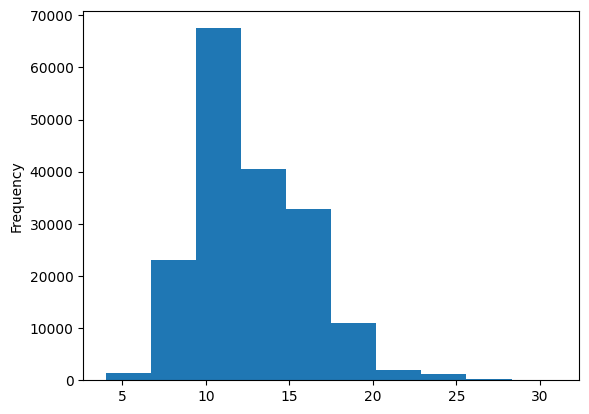

In [7]:
#Lets length of different lines
train_df.total_lines.plot.hist()

In [8]:
train_df=train_df.dropna()
val_df=val_df.dropna()
test_df=test_df.dropna()

### Get list of sentences
Convert abstract text lines into list

In [9]:
train_sentences=train_df.abstract_text.to_list()
val_sentences=val_df.abstract_text.to_list()
test_sentences=test_df.abstract_text.to_list()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [10]:
#View 10 lines of training sentences
train_sentences[:10]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

### Make Numerical Labels (ML model also require numeric labels)
Extract labels ('target columns') and encode into integers

#### Label Encoded

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder=LabelEncoder()
train_label_encoded=label_encoder.fit_transform(train_df['target'])
val_label_encoded=label_encoder.transform(val_df['target'])
test_label_encoded=label_encoder.transform(test_df['target'])

#train label encoded looks like?
train_label_encoded

array([3, 2, 2, ..., 4, 1, 1])

#### One Hot Encoded

In [12]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder=OneHotEncoder(sparse_output=False)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

# What one hot encoded target labels looks like?
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [13]:
#Get class names and number of classses from labelencoder instance
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## 3. Modelling Experiments...

We are going to trying out a bunch of different models and seeing which one works best. 

We will start with baseline model `(TF-IDF Random Forest Classifier)`

Creating Helper function to calculate model results for each score

In [14]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

def calculate_results(y_pred,y_true):
    """
    return a dicionary of score like accuracy,precision, recall and f1-score
    """
    results={
        "accuracy":accuracy_score(y_true,y_pred),
        "precision":precision_score(y_true,y_pred,average='weighted'),
        "recall":recall_score(y_true,y_pred,average='weighted'),
        "F1-score":f1_score(y_true,y_pred,average='weighted')
    }
    return results

### Preparing our data(the text) for deep sequence models
Before we start building deeper models, we've got create vectorization and embeddings layers

In [15]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [16]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [17]:
import numpy as np
import tensorflow as tf 
from tensorflow.keras import layers

In [18]:
#How long is each sentence on average?
sent_lens=[len(sentence.split()) for sentence in train_sentences]
sent_lens[:5]

[49, 27, 15, 14, 35]

In [19]:
avg_sent_len=np.mean(sent_lens)
max_sent_len=np.max(sent_lens)
min_sent_len=np.min(sent_lens)

avg_sent_len,max_sent_len,min_sent_len

(26.338269273494777, 296, 1)

(array([1.5999e+05, 1.8760e+04, 1.1510e+03, 9.9000e+01, 2.8000e+01,
        1.0000e+01, 2.0000e+00]),
 array([  1.        ,  43.14285714,  85.28571429, 127.42857143,
        169.57142857, 211.71428571, 253.85714286, 296.        ]),
 <BarContainer object of 7 artists>)

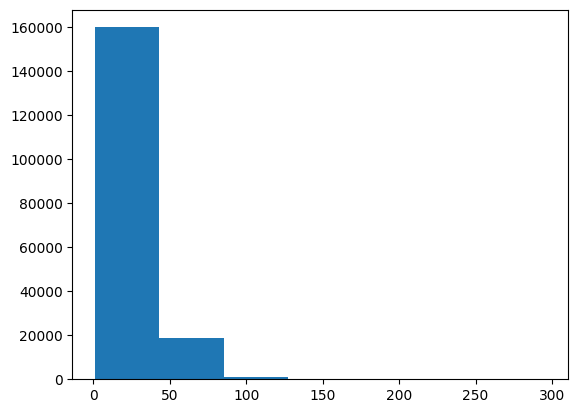

In [20]:
# What distribution looks like?
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=7)

In [21]:
# How long a sentence length over 95% of exampes?
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len

55

In [22]:
#Maximum sequence length is training sentence
max(sent_lens)

296

#### Create Text Vectorizer
We want to make a layer which maps our tansform words into numbers

In [23]:
#How many words are in the vocabulary(taken table-2 from research paper)
max_tokens=68000

In [24]:
#Create Text Vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer=TextVectorization(max_tokens=max_tokens,#number of words in vocabulary
                                 output_sequence_length=output_seq_len) #desired output length of vectorized sequence

In [25]:
#Adapt text vectorizer to training sequence
text_vectorizer.adapt(train_sentences)

In [26]:
#Test out text vectorizer on random sentences
import random
target_sequences=random.choice(train_sentences)
print(f"Text:\n{target_sequences}")
print(f"\nLength of Text:\n{len(target_sequences.split())}")
print(f"\nVectorized Text:\n{text_vectorizer([target_sequences])}")

Text:
We wish to assess the clinical and cost-effectiveness of remote monitoring of heart failure patients with cardiac implanted electronic devices .

Length of Text:
21

Vectorized Text:
[[   43 10101     6   216     2    47     3   936     4  2296   607     4
    260   292    12     7   342  3283  2014  1342     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [27]:
# How many words in our training vocabulary?
rct_20K_text_vocab=text_vectorizer.get_vocabulary()
print(f"Number of words in vocab:{len(rct_20K_text_vocab)}")
print(f"Most Common words in the vocab:{rct_20K_text_vocab[:5]}")
print(f"Least Common words in the vocab:{rct_20K_text_vocab[-5:]}")

Number of words in vocab:64841
Most Common words in the vocab:['', '[UNK]', 'the', 'and', 'of']
Least Common words in the vocab:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [28]:
# Get a config of our text vectoizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create Custom Text Embeddings 

In [29]:
token_embed=layers.Embedding(input_dim=len(rct_20K_text_vocab), #length of vocabulary
                            output_dim=128, #Note: different embedding sizes results in drastically different number of parameters
                            mask_zero=True, #use masking to handle variable sequence length (save space)
                            name='Token_embedding')

In [30]:
#Show example embedding
print(f"Sentence before vectorization:\n{target_sequences}")
vectorized_sentence=text_vectorizer([target_sequences])
print(f"Sentence after Vectorization:\n{vectorized_sentence}")
embedded_sentence=token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}")
print(f"Embedded Sentence Shape:\n{embedded_sentence.shape}")

Sentence before vectorization:
We wish to assess the clinical and cost-effectiveness of remote monitoring of heart failure patients with cardiac implanted electronic devices .
Sentence after Vectorization:
[[   43 10101     6   216     2    47     3   936     4  2296   607     4
    260   292    12     7   342  3283  2014  1342     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding:
[[[ 0.00035948  0.04210279 -0.03418998 ...  0.03044292  0.03647891
    0.01458887]
  [ 0.04540987 -0.0230855   0.02133134 ... -0.02258745 -0.04767275
    0.02917111]
  [ 0.03331994 -0.0082323  -0.00285674 ...  0.03028239 -0.00142533
    0.0166969 ]
  ...
  [ 0.02903713  0.0483814  -0.00965191 ...  0.03303638 -0.03424233
   -0.02183183]
  [ 0.02903713  0.0483814  -0.00965191 ...  0.03303638 -0.03424233
   -0.02183183]
  [ 0

## 4. Creating dataset (making sure our data loads fast as possible)
We're going to setup our data to run as fast possible with tensorflow tf.data.API, many of the steps here are discussed at length in the these resoucres:
* tensorflow data_performance guide
* tensorflow data guide

In [31]:
#Turn our data into tensorflow datasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
val_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [32]:
train_labels_one_hot.shape

(180040, 5)

In [33]:
#Take tensorslicesdataset and turn them into prefetch datasets
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset=val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1: Bi-lstm with token embeddings

In [34]:
#Create bi-lstm model with token embeddings
inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vectors=text_vectorizer(inputs) #vectorized input text
token_embedding=token_embed(text_vectors) #convert vectors to embeddings
x=layers.Bidirectional(layers.LSTM(64),name='bidirectional_lstm')(token_embedding)
outputs=layers.Dense(num_classes,activation='softmax')(x)

model_1=tf.keras.Model(inputs,outputs)

#Compile the model
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [35]:
#Model Summary 
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 Token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 bidirectional_lstm (Bidire  (None, 128)               98816     
 ctional)                                                        
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                             

In [36]:
#Fit the model 
history_model_1=model_1.fit(train_dataset,
                           steps_per_epoch=int(0.1*len(train_dataset)),
                           epochs=20,
                           validation_data=valid_dataset,
                           validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/20
562/562 [==============================] - 31s 40ms/step - loss: 0.7772 - accuracy: 0.7086 - val_loss: 0.6032 - val_accuracy: 0.7779
Epoch 2/20
562/562 [==============================] - 9s 16ms/step - loss: 0.5895 - accuracy: 0.7803 - val_loss: 0.5788 - val_accuracy: 0.7806
Epoch 3/20
562/562 [==============================] - 8s 14ms/step - loss: 0.5534 - accuracy: 0.7920 - val_loss: 0.5258 - val_accuracy: 0.8009
Epoch 4/20
562/562 [==============================] - 8s 13ms/step - loss: 0.5347 - accuracy: 0.8060 - val_loss: 0.5070 - val_accuracy: 0.8049
Epoch 5/20
562/562 [==============================] - 8s 14ms/step - loss: 0.5361 - accuracy: 0.8033 - val_loss: 0.4901 - val_accuracy: 0.8142
Epoch 6/20
562/562 [==============================] - 8s 14ms/step - loss: 0.5277 - accuracy: 0.8049 - val_loss: 0.4796 - val_accuracy: 0.8228
Epoch 7/20
562/562 [==============================] - 8s 15ms/step - loss: 0.5052 - accuracy: 0.8129 - val_loss: 0.4822 - val_accuracy: 0.817

In [37]:
#Evaluate on whole validation set 
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.4691 - accuracy: 0.8269


[0.4690673351287842, 0.8268899917602539]

In [38]:
#make Predictions
model_1_pred_probs=model_1.predict(valid_dataset)
model_1_pred_probs[:5]

945/945 [==============================] - 6s 4ms/step


array([[4.10152078e-01, 3.07634741e-01, 3.17732058e-02, 2.12379545e-01,
        3.80605422e-02],
       [6.23623133e-01, 2.05144212e-01, 3.25223245e-03, 1.58280939e-01,
        9.69951134e-03],
       [4.07833368e-01, 1.70708925e-03, 2.97994050e-03, 5.87155402e-01,
        3.24122404e-04],
       [4.40015644e-03, 9.67588159e-04, 9.42594647e-01, 6.01216173e-03,
        4.60254587e-02],
       [1.91486592e-03, 1.41819725e-02, 8.00171256e-01, 2.65015685e-03,
        1.81081802e-01]], dtype=float32)

In [39]:
#Convert the pred probs into classes labels
model_1_preds=tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [40]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [41]:
#Calculate model_1 results
model_1_results=calculate_results(y_true=val_label_encoded,
                                  y_pred=model_1_preds.numpy())
model_1_results

{'accuracy': 0.8268899774923871,
 'precision': 0.8269166059106269,
 'recall': 0.8268899774923871,
 'F1-score': 0.8241879374413199}

## Model 2 : Feature Extraction with Pretrained token embeddings

Now Lets use pretrained word embeddings from tensorflow hub, Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe Embeddings, however we're going to stick with the later created `USE pretrained Embeddings`

In [42]:
#Download pretrained tensorflow as hub
import tensorflow_hub as hub

tf_hub_embedding_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                     trainable=False,
                                     input_shape=[],
                                     dtype=tf.string,
                                     name='universal_sentence_encoder')

In [43]:
# Test out the pretrained embedding on a random sentences
random_train_sentences=random.choice(train_sentences)
print(f"Train Sentences:\n{random_train_sentences}")
use_embedding_sentences=tf_hub_embedding_layer([random_train_sentences])
print(f"Sentence after embedding:\n{use_embedding_sentences}")
print(f"Length of sentences embedding:{len(use_embedding_sentences[0])}")

Train Sentences:
Spatial QRS-T angle was automatically measured from standard electrocardiogram of @ HIV-infected individuals without baseline widened spatial QRS-T angle from the Strategies for Management of Antiretroviral Therapy -LSB- SMART -RSB- , a clinical trial comparing two antiretroviral treatment strategies -LSB- Drug Conservation ( DC ) vs. Viral Suppression ( VS ) -RSB- .
Sentence after embedding:
[[-4.79575880e-02 -5.12452237e-02 -4.14179154e-02 -6.20081872e-02
   4.27714037e-03 -6.01012744e-02  5.16825058e-02 -3.77681255e-02
  -8.34012311e-03  6.83881342e-02  7.42478743e-02  5.77939267e-04
   1.74188763e-02 -3.08401044e-02  5.85338846e-02  1.70773928e-04
  -7.00980797e-02  3.32876891e-02 -5.58421426e-02 -8.69341288e-03
   2.39635557e-02 -2.79474743e-02 -6.44711852e-02  2.51036719e-03
   6.48401305e-02 -4.60435823e-02 -1.90900033e-03  3.22870389e-02
   1.23286908e-02 -3.42824645e-02 -4.37077135e-03  7.66127333e-02
   5.74303605e-02  5.29742986e-02  5.25883399e-02 -3.789958

### Building and fitting an NLP feature Extraction model using pretrained embeddings tensorflow hub

In [44]:
#Define feature extraction model using Tf Hub layers
inputs=layers.Input(shape=(),dtype=tf.string) 
pretrained_embedding=tf_hub_embedding_layer(inputs) #tokenize the text and create embedding of each sequence (512 long vectors)
x=layers.Dense(128,activation='relu')(pretrained_embedding)
#Note: U could add more layers here if you wanted to
outputs=layers.Dense(num_classes,activation='softmax')(x) #Create an output layer 


#Create a model
model_2=tf.keras.Model(inputs,outputs,name='model_2_USE_feature_extractor')

#Compile the model
model_2.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

#Architecure of model_2
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [45]:
#Fit the model
history_model_2=model_2.fit(train_dataset,
                           steps_per_epoch=int(0.1*len(train_dataset)),
                           epochs=20,
                           validation_data=valid_dataset,
                           validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/20
562/562 [==============================] - 9s 11ms/step - loss: 0.9149 - accuracy: 0.6517 - val_loss: 0.7964 - val_accuracy: 0.6908
Epoch 2/20
562/562 [==============================] - 6s 10ms/step - loss: 0.7698 - accuracy: 0.7008 - val_loss: 0.7559 - val_accuracy: 0.7031
Epoch 3/20
562/562 [==============================] - 6s 10ms/step - loss: 0.7552 - accuracy: 0.7100 - val_loss: 0.7418 - val_accuracy: 0.7144
Epoch 4/20
562/562 [==============================] - 6s 10ms/step - loss: 0.7217 - accuracy: 0.7221 - val_loss: 0.7125 - val_accuracy: 0.7281
Epoch 5/20
562/562 [==============================] - 6s 10ms/step - loss: 0.7287 - accuracy: 0.7210 - val_loss: 0.6917 - val_accuracy: 0.7367
Epoch 6/20
562/562 [==============================] - 6s 11ms/step - loss: 0.7187 - accuracy: 0.7246 - val_loss: 0.6812 - val_accuracy: 0.7350
Epoch 7/20
562/562 [==============================] - 6s 10ms/step - loss: 0.6854 - accuracy: 0.7397 - val_loss: 0.6653 - val_accuracy: 0.7480

In [46]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 8s 9ms/step - loss: 0.6572 - accuracy: 0.7490


[0.6571904420852661, 0.7489739060401917]

In [47]:
#MAke predictions with feature extractio model
model_2_pred_probs=model_2.predict(valid_dataset)
model_2_pred_probs[:5]

945/945 [==============================] - 8s 8ms/step


array([[4.5556673e-01, 4.1604078e-01, 5.9325260e-04, 1.1787445e-01,
        9.9247936e-03],
       [3.6713713e-01, 5.4732931e-01, 2.0286036e-03, 8.2401007e-02,
        1.1039533e-03],
       [4.2024624e-01, 3.9752338e-02, 2.5615254e-02, 4.7461873e-01,
        3.9767411e-02],
       [9.2470022e-03, 4.5225028e-02, 7.8432053e-01, 6.9866967e-03,
        1.5422076e-01],
       [7.7223293e-03, 5.6167677e-02, 5.1017708e-01, 3.2281117e-03,
        4.2270485e-01]], dtype=float32)

In [48]:
#Convert probabilities to labels
model_2_preds=tf.argmax(model_2_pred_probs,axis=1)
model_2_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 3, 2, 2])>

In [49]:
#Calculate reesults of model_2 
model_2_results=calculate_results(y_true=val_label_encoded,
                         y_pred=model_2_preds)
model_2_results

{'accuracy': 0.7489739176486164,
 'precision': 0.7443508017066346,
 'recall': 0.7489739176486164,
 'F1-score': 0.7442166097964635}

## Model 3 : Bidirectional-lstm with character embeddings

the paper we've replicating states they used a combination of token and character-level embeddings 
Previously, we have made token level embeddings but we need similar for character if we want to use char-level emebeddings.

`Character embeddings` are representation of text at the character level rather than at the words sentence level.
* `What are they?` Character embeddings are numerical vectors that represent individual characters instead of entire words or phrases.
* `Why use them?` They are especially useful for capturing subword patterns such as phrases and spelling variations. Handling out of vocab word is easier because every word is built from characters.

#### Create a character-level tokenizer

In [50]:
# make function to split sentences into characters
def split_text_into_chars(text):
    return " ".join(list(text))

#Text splittinf non-character level sequence into characters
split_text_into_chars(random_train_sentences)

'S p a t i a l   Q R S - T   a n g l e   w a s   a u t o m a t i c a l l y   m e a s u r e d   f r o m   s t a n d a r d   e l e c t r o c a r d i o g r a m   o f   @   H I V - i n f e c t e d   i n d i v i d u a l s   w i t h o u t   b a s e l i n e   w i d e n e d   s p a t i a l   Q R S - T   a n g l e   f r o m   t h e   S t r a t e g i e s   f o r   M a n a g e m e n t   o f   A n t i r e t r o v i r a l   T h e r a p y   - L S B -   S M A R T   - R S B -   ,   a   c l i n i c a l   t r i a l   c o m p a r i n g   t w o   a n t i r e t r o v i r a l   t r e a t m e n t   s t r a t e g i e s   - L S B -   D r u g   C o n s e r v a t i o n   (   D C   )   v s .   V i r a l   S u p p r e s s i o n   (   V S   )   - R S B -   .'

In [51]:
#Split sequences-level data splits into character-level data splits
train_chars=[split_text_into_chars(sentence) for sentence in train_sentences]
val_chars=[split_text_into_chars(sentence) for sentence in val_sentences]
test_chars=[split_text_into_chars(sentence) for sentence in test_sentences]
train_chars[:3]

['T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .',
 'A   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [52]:
# WHat average character length?
chars_lens=[len(sentence) for sentence in train_sentences]
mean_char_len=np.mean(chars_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

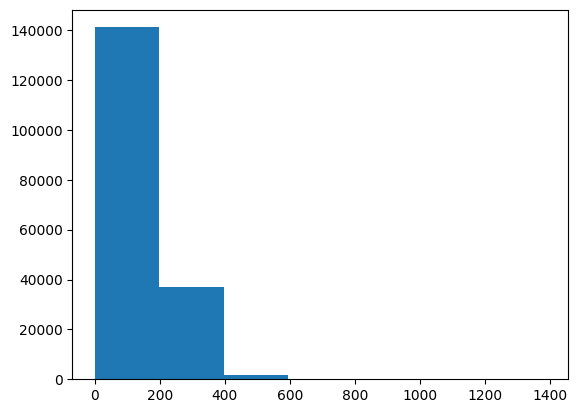

In [53]:
#Check distribution of our sequences at character level
import matplotlib.pyplot as plt
plt.hist(chars_lens,bins=7)

In [54]:
# Find the character lengths covers 95% of sequences
output_seq_char_len=int(np.percentile(chars_lens,95))
output_seq_char_len

290

In [55]:
#Get all the keywords characters
import string
alphabet=string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [56]:
#Create character level tokenizer istance
NUM_CHARS_TOKENS=len(alphabet)
char_vectorizer=TextVectorization(max_tokens=NUM_CHARS_TOKENS,
                                 output_sequence_length=output_seq_char_len,
                                 standardize=None,
                                 name='char_vectorizer')

In [57]:
#Adapt the character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [58]:
#Check characters vocab stats
char_vocab=char_vectorizer.get_vocabulary()
print(f"Number of characters in vocab:{len(char_vocab)}")
print(f"5 Most Common Characters:{char_vocab[:5]}")
print(f"5 Least Common Characters:{char_vocab[-5:]}")

Number of characters in vocab:68
5 Most Common Characters:['', '[UNK]', 'e', 't', 'i']
5 Least Common Characters:['+', 'X', '`', '>', 'J']


In [59]:
# TEst out character vectorizer
random_train_chars=random.choice(train_chars)
print(f"Text:\n{random_train_chars}\n")
print(f"Length of random_train_chars:{len(random_train_chars.split())}")
vectorized_chars=char_vectorizer([random_train_chars])
print(f"Vectorized Text:\n{vectorized_chars}")
print(f"Length of Vectorizd Text:{len(vectorized_chars[0])}")

Text:
P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   e i t h e r   a   s l e e p   e x t e n s i o n   g r o u p   (   g r a d u a l   s l e e p   e x t e n s i o n   b y   a d v a n c i n g   b e d t i m e s   i n   t h e   e v e n i n g   a n d   r e c e i v i n g   s l e e p   h y g i e n e   a d v i c e   )   o r   t o   a   c o n t r o l   g r o u p   (   n o   i n s t r u c t i o n   )   .

Length of random_train_chars:177
Vectorized Text:
[[32  5  8  3  4 12  4 14  5  6  3  9 21  2  8  2  8  5  6 10  7 15 11 20
   5  9  9  4 18  6  2 10  3  7  2  4  3 13  2  8  5  9 11  2  2 14  2 36
   3  2  6  9  4  7  6 18  8  7 16 14 28 18  8  5 10 16  5 11  9 11  2  2
  14  2 36  3  2  6  9  4  7  6 23 20  5 10 22  5  6 12  4  6 18 23  2 10
   3  4 15  2  9  4  6  3 13  2  2 22  2  6  4  6 18  5  6 10  8  2 12  2
   4 22  4  6 18  9 11  2  2 14 13 20 18  4  2  6  2  5 10 22  4 12  2 27
   7  8  3  7  5 12  7  6  3  8  7 11 18  8  7 16 14 28  6  7  4  6  9  3
 

### Creating a character-level embedding

In [60]:
#Create char embedding layer
char_embed=layers.Embedding(input_dim=len(char_vocab),
                           output_dim=25,
                           mask_zero=True,
                           name='char_embed')

In [61]:
#Tes our character embedding layer
print(f"Charified text:\n{random_train_chars}\n")
char_embed_example=char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded Chars: after vectorization and embedding:\n{char_embed_example}\n")
print(f"Character embedding shape:{char_embed_example.shape}")

Charified text:
P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   e i t h e r   a   s l e e p   e x t e n s i o n   g r o u p   (   g r a d u a l   s l e e p   e x t e n s i o n   b y   a d v a n c i n g   b e d t i m e s   i n   t h e   e v e n i n g   a n d   r e c e i v i n g   s l e e p   h y g i e n e   a d v i c e   )   o r   t o   a   c o n t r o l   g r o u p   (   n o   i n s t r u c t i o n   )   .

Embedded Chars: after vectorization and embedding:
[[[-0.01489394 -0.01197177 -0.03216946 ...  0.0341871   0.0427455
   -0.00919033]
  [-0.00833417  0.0129011  -0.03077326 ...  0.04671546 -0.02092203
   -0.0387884 ]
  [ 0.04671736  0.00441564 -0.04229115 ... -0.04033108 -0.01015613
   -0.01762853]
  ...
  [ 0.03764007  0.04870865  0.00698764 ... -0.04614167 -0.03644576
   -0.01091272]
  [ 0.03764007  0.04870865  0.00698764 ... -0.04614167 -0.03644576
   -0.01091272]
  [ 0.03764007  0.04870865  0.00698764 ... -0.04614167 -0.03644576
   -0.01091272]]]

Ch

#### Building a bidirectional-lstm model to fit on character embeddings

In [62]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
char_vectors=char_vectorizer(inputs)
char_embedding=char_embed(char_vectors)
x=layers.Bidirectional(layers.LSTM(64),name='bidirectional_lstm')(char_embedding)
outputs=layers.Dense(num_classes,activation='softmax')(x)

model_3=tf.keras.Model(inputs,outputs)

#Compile the model
model_3.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

#Summary of model
model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1700      
                                                                 
 bidirectional_lstm (Bidire  (None, 128)               46080     
 ctional)                                                        
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 48425 (189.16 KB)
Trainable params: 48425 (18

In [63]:
#Create char level dataset
train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [64]:
#Fit the model on chars only 
model_3_history=model_3.fit(train_char_dataset,
                           steps_per_epoch=int(0.1*len(train_char_dataset)),
                           epochs=20,
                           validation_data=val_char_dataset,
                           validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/20
562/562 [==============================] - 24s 30ms/step - loss: 1.2689 - accuracy: 0.4565 - val_loss: 1.1453 - val_accuracy: 0.5209
Epoch 2/20
562/562 [==============================] - 13s 23ms/step - loss: 1.1113 - accuracy: 0.5340 - val_loss: 1.1269 - val_accuracy: 0.5283
Epoch 3/20
562/562 [==============================] - 12s 21ms/step - loss: 1.0949 - accuracy: 0.5543 - val_loss: 1.0913 - val_accuracy: 0.5502
Epoch 4/20
562/562 [==============================] - 12s 21ms/step - loss: 1.0457 - accuracy: 0.5772 - val_loss: 1.0103 - val_accuracy: 0.5951
Epoch 5/20
562/562 [==============================] - 12s 22ms/step - loss: 1.0219 - accuracy: 0.5915 - val_loss: 1.0086 - val_accuracy: 0.5914
Epoch 6/20
562/562 [==============================] - 12s 21ms/step - loss: 1.0102 - accuracy: 0.5947 - val_loss: 0.9913 - val_accuracy: 0.6067
Epoch 7/20
562/562 [==============================] - 12s 22ms/step - loss: 0.9719 - accuracy: 0.6102 - val_loss: 0.9678 - val_accuracy:

In [65]:
# Make predictions with character embeddigs
model_3_pred_probs=model_3.predict(val_char_dataset)
model_3_pred_probs[:10]


945/945 [==============================] - 10s 9ms/step


array([[0.25626606, 0.56058854, 0.0414898 , 0.08600512, 0.05565043],
       [0.2525112 , 0.43454888, 0.08018558, 0.11712211, 0.11563229],
       [0.38283798, 0.12237295, 0.04658157, 0.40360656, 0.04460099],
       [0.00526073, 0.00529721, 0.9126893 , 0.00294307, 0.07380967],
       [0.00168994, 0.0050103 , 0.9233576 , 0.00114575, 0.06879643],
       [0.00172473, 0.0033143 , 0.88958293, 0.00199047, 0.10338758],
       [0.00396669, 0.00618917, 0.89091045, 0.0019537 , 0.09697996],
       [0.15337825, 0.27171308, 0.3061289 , 0.04163494, 0.22714484],
       [0.0017678 , 0.00710571, 0.077093  , 0.00118753, 0.91284597],
       [0.18972404, 0.05942236, 0.59238267, 0.09587546, 0.06259549]],
      dtype=float32)

In [66]:
#Convert the predictions probabilities to class labels
model_3_preds=tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [67]:
#Calculate  the results for bidirectional chars only
model_3_results=calculate_results(y_pred=model_3_preds,
                                 y_true=val_label_encoded)
model_3_results

{'accuracy': 0.6513967959751092,
 'precision': 0.6656352910309662,
 'recall': 0.6513967959751092,
 'F1-score': 0.6489522276284218}

## Model 4: Combining token embeddings + character embeddings(hybrid embedding layer )

1. Create token-level embedding model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with concatenate (`layers.concatenate`) layer
4. Build a Series of output layer on top of 3 similar Figure 1 and section 4.2 of research paper of pub_med_rct_200k
5. Construct a model which takes token and embeddings and character-level sequences as input and produces sequence label probabilities as output.

In [68]:
# 1. Setup token inputs model
token_inputs=layers.Input(shape=(1,),dtype=tf.string,name='token_input')
token_vectors=text_vectorizer(token_inputs)
token_embeddings=token_embed(token_vectors)
token_bi_lstm=layers.Bidirectional(layers.LSTM(64),name='bi-lstm_1')(token_embeddings)
token_model=tf.keras.Model(inputs=token_inputs,
                          outputs=token_bi_lstm)

# 2. Setup char inputs model
char_inputs=layers.Input(shape=(1,),dtype=tf.string,name='char_input')
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(64),name='bi-lstm_2')(char_embeddings)
char_model=tf.keras.Model(inputs=char_inputs,
                         outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embeding)
token_char_concate=layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                char_model.output])

# 4. Create output layers- addition of dropout saied in paper
combined_dropout=layers.Dropout(0.5)(token_char_concate)
combined_dense=layers.Dense(128,activation='relu')(combined_dropout)
final_dropout=layers.Dropout(0.5)(combined_dense)
output_layer=layers.Dense(num_classes,activation='softmax')(final_dropout)

# 5. Construct a model with char and token inputs
model_4=tf.keras.Model(inputs=[token_model.input,char_model.input],
                      outputs=output_layer,
                      name='model_4_token_char_embedding')

In [69]:
# Get a model summary
model_4.summary()

Model: "model_4_token_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 55)                   0         ['token_input[0][0]']         
 ctorization)                                                                                     
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['c

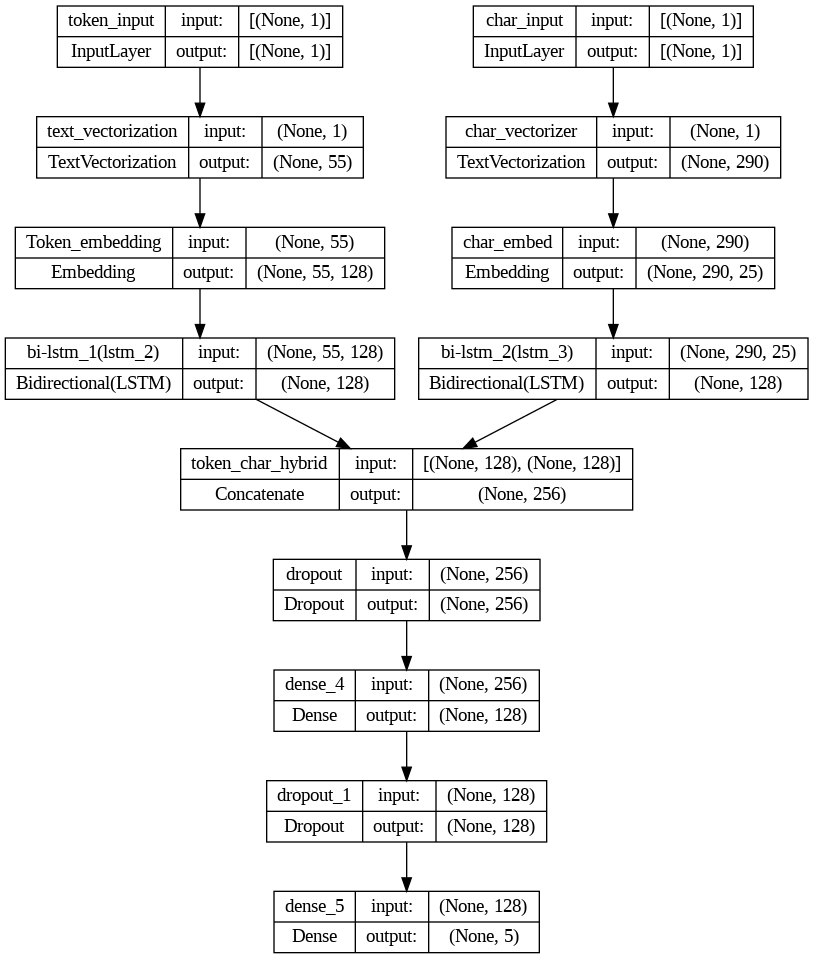

In [70]:
#Plot hybrid token and character model
from tensorflow.keras.utils import plot_model

plot_model(model_4,show_shapes=True)

In [71]:
#Compile the model
model_4.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

#### Combining token and Character data into tf.data.Dataset

In [72]:
# Train dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Test dataset
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [73]:
#Check out training and validation dataset
train_char_token_dataset,val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character level sequences

In [74]:
#Fit the model on tokens and chars
history_model_4=model_4.fit(train_char_token_dataset,
                           steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                           epochs=20,
                           validation_data=val_char_token_dataset,
                           validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/20
562/562 [==============================] - 47s 60ms/step - loss: 0.6090 - accuracy: 0.7793 - val_loss: 0.5073 - val_accuracy: 0.8155
Epoch 2/20
562/562 [==============================] - 19s 34ms/step - loss: 0.4825 - accuracy: 0.8280 - val_loss: 0.5109 - val_accuracy: 0.8032
Epoch 3/20
562/562 [==============================] - 17s 30ms/step - loss: 0.4641 - accuracy: 0.8379 - val_loss: 0.4901 - val_accuracy: 0.8138
Epoch 4/20
562/562 [==============================] - 17s 31ms/step - loss: 0.4501 - accuracy: 0.8440 - val_loss: 0.4947 - val_accuracy: 0.8142
Epoch 5/20
562/562 [==============================] - 17s 31ms/step - loss: 0.4522 - accuracy: 0.8397 - val_loss: 0.4802 - val_accuracy: 0.8221
Epoch 6/20
562/562 [==============================] - 18s 32ms/step - loss: 0.4515 - accuracy: 0.8429 - val_loss: 0.4781 - val_accuracy: 0.8251
Epoch 7/20
562/562 [==============================] - 18s 31ms/step - loss: 0.4232 - accuracy: 0.8503 - val_loss: 0.4820 - val_accuracy:

In [75]:
#Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.5051 - accuracy: 0.8213


[0.5050513744354248, 0.8212630748748779]

In [76]:
#Make predictions using token character model hybrid
model_4_pred_probs=model_4.predict(val_char_token_dataset)

945/945 [==============================] - 14s 11ms/step


In [77]:
#Format to pred labels
model_4_preds=tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [78]:
#Get results of token-char-hybrid model
model_4_results=calculate_results(y_true=val_label_encoded,
                                 y_pred=model_4_preds)
model_4_results

{'accuracy': 0.8212630742751225,
 'precision': 0.8185480038836436,
 'recall': 0.8212630742751225,
 'F1-score': 0.8182750126166436}

## Model 5 : Tribrid model using token + character + postional embeddings

In [79]:
train_df.head()

,abstract_id,line_id,abstract_text,line_number,total_lines,target
0,24293578,24293578_0_12,To investigate the efficacy of @ weeks of dail...,0,12,OBJECTIVE
1,24293578,24293578_1_12,A total of @ patients with primary knee OA wer...,1,12,METHODS
2,24293578,24293578_2_12,Outcome measures included pain reduction and i...,2,12,METHODS
3,24293578,24293578_3_12,Pain was assessed using the visual analog pain...,3,12,METHODS
4,24293578,24293578_4_12,Secondary outcome measures included the Wester...,4,12,METHODS


**Note**: Any engineered features used at training a model need to be available at test time. In our case line numbers and total lines are available.

### Create Positional embeddings

In [80]:
#How many different line numbers are there?
train_df['line_number'].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

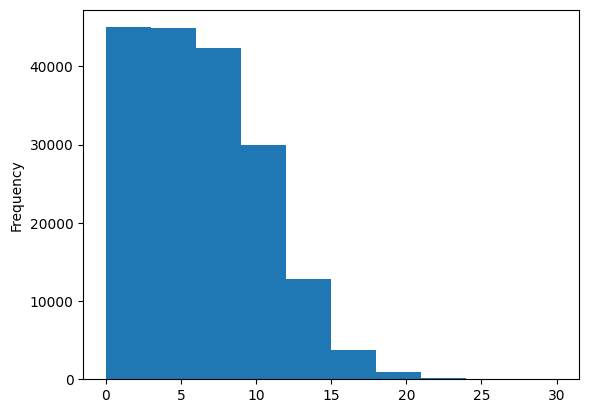

In [81]:
#Check the distribution of "line_numbers" column
train_df.line_number.plot.hist()

In [82]:
#USe tensorflow to create a one-hot-encoded tensors of our lines-number columns
train_line_numbers_one_hot=tf.one_hot(train_df['line_number'].to_numpy(),depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df['line_number'].to_numpy(),depth=15)
val_line_numbers_one_hot=tf.one_hot(val_df['line_number'].to_numpy(),depth=15)

Now we've encoded our line numbers features lets do the same for our total line features

In [83]:
#How many different numbers of lines are there?
train_df['total_lines'].value_counts()

total_lines
12    24468
11    23639
13    22113
10    19400
14    18438
15    14610
9     12285
16    10768
8      7464
17     7429
18     5202
7      3353
19     3344
20     2480
21     1281
6      1146
22      770
23      759
24      264
5       215
25      200
26      182
27       81
29       58
4        32
31       31
28       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

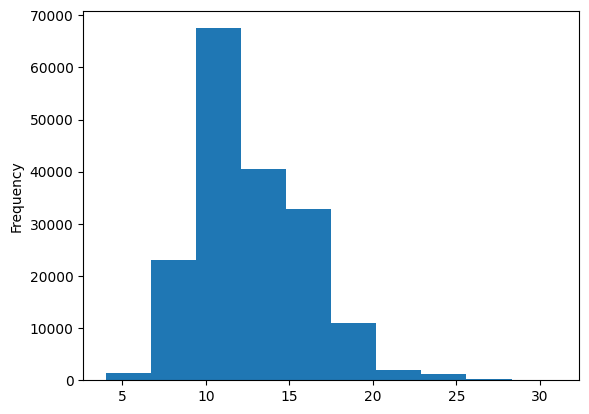

In [84]:
#Visualise the total lines
train_df['total_lines'].plot.hist()

In [85]:
#Check the average of total lines
np.percentile(train_df['total_lines'],97)

20.0

In [86]:
#Use tensorflow to create one-hot-encoded tensors of our 'total_lines' features 
train_total_lines_one_hot=tf.one_hot(train_df['total_lines'].to_numpy(),depth=20)
test_total_lines_one_hot=tf.one_hot(test_df['total_lines'].to_numpy(),depth=20)
val_total_lines_one_hot=tf.one_hot(val_df['total_lines'].to_numpy(),depth=20)

### Building a tribrid embedding model

1. Creating a token-level model
2. Create a character-level model
3. Create a model for the line-number features
4. Create a model for the total_lines features
5. Combine the outputs of 1 & 2 using tf.keras.layers.concatenate
6. Combine the outputs of 3,4 & 5 using tf.keras.layers.concatenat
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of the 1,2,3 and 4 outputs of the into a tf.keras.model

In [87]:
# 1. Setup token inputs model
token_inputs=layers.Input(shape=(1,),dtype=tf.string,name='token_input')
token_vectors=text_vectorizer(token_inputs)
token_embeddings=token_embed(token_vectors)
token_bi_lstm=layers.Bidirectional(layers.LSTM(64),name='bi-lstm_1')(token_embeddings)
token_model=tf.keras.Model(inputs=token_inputs,
                          outputs=token_bi_lstm)

# 2. Setup char inputs model
char_inputs=layers.Input(shape=(1,),dtype=tf.string,name='char_input')
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(64),name='bi-lstm_2')(char_embeddings)
char_model=tf.keras.Model(inputs=char_inputs,
                         outputs=char_bi_lstm)

# 3. Setup line number model
line_number_inputs=layers.Input(shape=[15,],dtype=tf.float32,name='line_number_inputs')
line_number_dense=layers.Dense(32,activation='relu')(line_number_inputs)
line_number_model=tf.keras.Model(inputs=line_number_inputs,
                                outputs=line_number_dense)

# 4. Setup total lines model
total_lines_inputs=layers.Input(shape=[20,],dtype=tf.float32)
total_lines_dense=layers.Dense(32,activation='relu')(total_lines_inputs)
total_lines_model=tf.keras.Model(inputs=total_lines_inputs,
                                outputs=total_lines_dense)

# 5. Combine the token and char embedding into a hybrid embeddings
combined_embeddings=layers.Concatenate(name='char_token_hybrid_embeddings')([token_model.output,
                                                                            char_model.output])
z=layers.Dense(256,activation='relu')(combined_embeddings)
z=layers.Dropout(0.5)(z)

# 6. Combine the positional embeddings with combined token and char embeddings
tribrid_embeddings=layers.Concatenate(name='char_token_positional_embeddings')([line_number_model.output,
                                                                               total_lines_model.output,
                                                                               z])
# 7. Create output layer
output_layer=layers.Dense(num_classes,activation='softmax')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5=tf.keras.Model(inputs=[line_number_model.input,
                              total_lines_model.input,
                              token_model.input,
                              char_model.input],
                      outputs=output_layer,name='model_5_tribrid_embedding_model')

In [88]:
#get a summary of tribrid embedding models 
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 55)                   0         ['token_input[0][0]']         
 ctorization)                                                                                     
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         

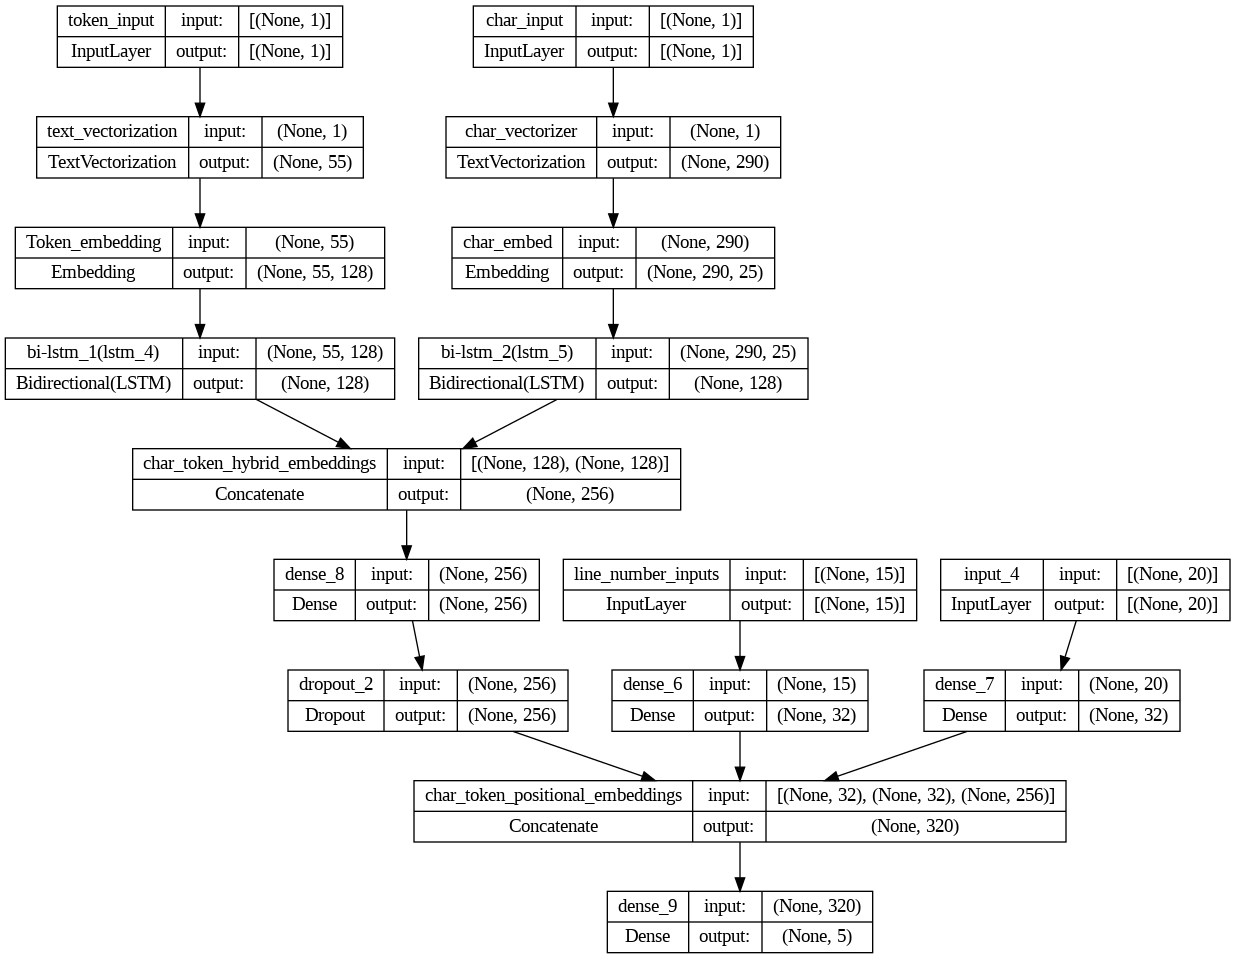

In [89]:
#Plot the model_5 visually
plot_model(model_5,show_shapes=True)

#### What is Label_Smoothing?

Ans. For example if our model gets too confident on single class.
(e.g. its prediction probability is really high) , it may be stuck on that class and not consider other classes...

Really Confident : `[0.0,0.0,1.0,0.0,0.1]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn hopefully proving generalization: `[0.01,0.01,0.96,0.01,0.01]`

In [90]:
#Compile the model 
model_5.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

### Create tribrid embedding datasets using tf.data

In [91]:
# Create training dataset
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((
    train_line_numbers_one_hot,  # Line numbers one-hot
    train_total_lines_one_hot,   # Total lines one-hot
    train_sentences,             # Sentences
    train_chars                  # Characters
))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Create validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((
    val_line_numbers_one_hot,  # Line numbers one-hot
    val_total_lines_one_hot,   # Total lines one-hot
    val_sentences,             # Sentences
    val_chars                  # Characters
))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Create test dataset
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((
    test_line_numbers_one_hot,  # Line numbers one-hot
    test_total_lines_one_hot,   # Total lines one-hot
    test_sentences,             # Sentences
    test_chars                  # Characters
))

test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [92]:
#Check input shapes
train_char_token_pos_dataset,val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, Evaluating and Making predictions with our tribrid model

In [93]:
# Train the model
history_model_5 = model_5.fit(
    train_char_token_pos_dataset, 
    steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
    epochs=20,  # You can set to 20 as needed
    validation_data=val_char_token_pos_dataset,
    validation_steps=int(0.1 * len(val_char_token_pos_dataset))
)

Epoch 1/20
562/562 [==============================] - 48s 60ms/step - loss: 0.4786 - accuracy: 0.8279 - val_loss: 0.4337 - val_accuracy: 0.8381
Epoch 2/20
562/562 [==============================] - 19s 34ms/step - loss: 0.3142 - accuracy: 0.8896 - val_loss: 0.3973 - val_accuracy: 0.8471
Epoch 3/20
562/562 [==============================] - 18s 31ms/step - loss: 0.2849 - accuracy: 0.8996 - val_loss: 0.3847 - val_accuracy: 0.8494
Epoch 4/20
562/562 [==============================] - 17s 31ms/step - loss: 0.2761 - accuracy: 0.9040 - val_loss: 0.3803 - val_accuracy: 0.8544
Epoch 5/20
562/562 [==============================] - 18s 31ms/step - loss: 0.2670 - accuracy: 0.9049 - val_loss: 0.3805 - val_accuracy: 0.8554
Epoch 6/20
562/562 [==============================] - 18s 32ms/step - loss: 0.2640 - accuracy: 0.9028 - val_loss: 0.3755 - val_accuracy: 0.8541
Epoch 7/20
562/562 [==============================] - 18s 33ms/step - loss: 0.2498 - accuracy: 0.9074 - val_loss: 0.3774 - val_accuracy:

In [94]:
model_5.evaluate(train_char_token_pos_dataset)

5627/5627 [==============================] - 65s 12ms/step - loss: 0.2397 - accuracy: 0.9106


[0.23970818519592285, 0.9106309413909912]

In [95]:
#Make predictions with char token pos model
model_5_pred_probs=model_5.predict(val_char_token_pos_dataset)
model_5_preds=tf.argmax(model_5_pred_probs,axis=1)
model_5_preds[:10]

945/945 [==============================] - 14s 11ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [96]:
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [97]:
val_label_encoded.shape

(30212,)

In [98]:
model_5_results=calculate_results(y_pred=model_5_preds,
                                 y_true=tf.convert_to_tensor(val_label_encoded))
model_5_results

{'accuracy': 0.8486363034555806,
 'precision': 0.8528207121112718,
 'recall': 0.8486363034555806,
 'F1-score': 0.8461800834956058}

## Compare Model results

In [99]:
#Combine model results into dataframe
all_model_results=pd.DataFrame({"model_1_custom_token_embedding":model_1_results,
                                "model_2_pretrained_tokenembedding":model_2_results,
                               "model_3_custom_char_embedding":model_3_results,
                               "model_4_hybrid_char_token_embedding":model_4_results,
                               "model_5_char_token_pos_embedding":model_5_results})
all_model_results=all_model_results.transpose()
all_model_results

,accuracy,precision,recall,F1-score
model_1_custom_token_embedding,0.826890,0.826917,0.826890,0.824188
model_2_pretrained_tokenembedding,0.748974,0.744351,0.748974,0.744217
model_3_custom_char_embedding,0.651397,0.665635,0.651397,0.648952
model_4_hybrid_char_token_embedding,0.821263,0.818548,0.821263,0.818275
model_5_char_token_pos_embedding,0.848636,0.852821,0.848636,0.846180


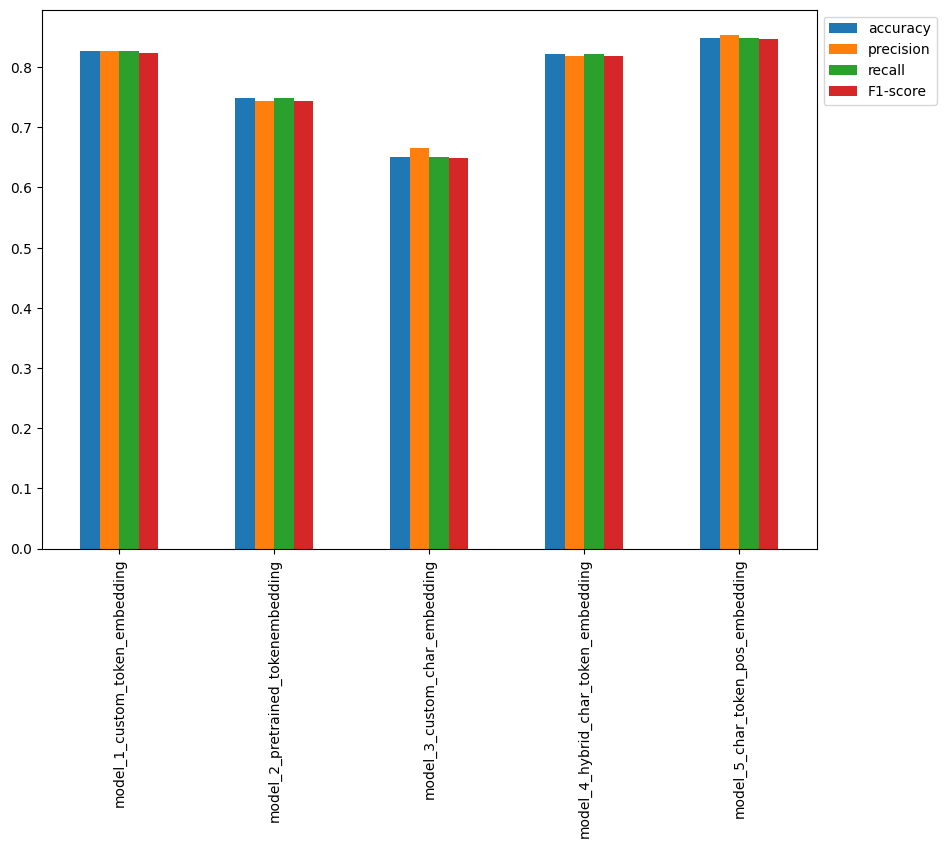

In [100]:
#Plot and compare all model results
all_model_results.plot(kind='bar', figsize=(10, 7))

# Add legend with specific location
plt.legend(bbox_to_anchor=(1.0, 1.0))

# Save the plot as a .png file (you can change the file format as needed)
plt.savefig('model_comparison_bar_plot.png', format='png', bbox_inches='tight', dpi=300)

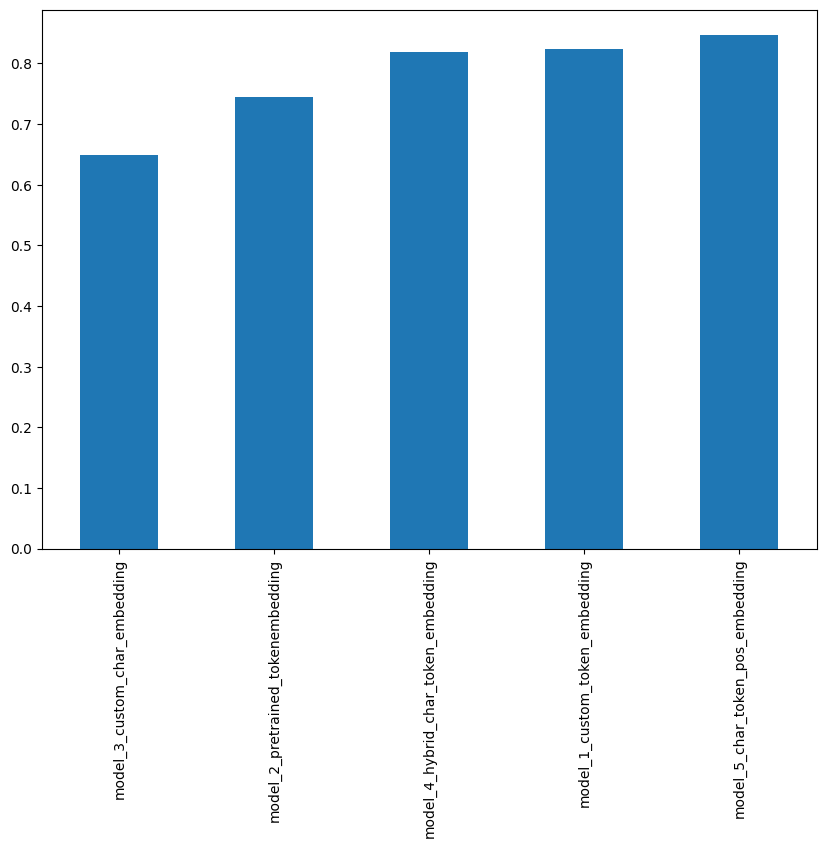

In [101]:
# Sort models results by f1-score
all_model_results.sort_values('F1-score',ascending=True)['F1-score'].plot(kind='bar',figsize=(10,7));

## Save the model

In [102]:
model_5.save('skimlit_tribrid_model.keras')

## Testing our tribrid model on testing dataset

In [103]:
model_5_test_pred_probs=model_5.predict(test_char_token_pos_dataset)
model_5_test_preds=tf.argmax(model_5_test_pred_probs,axis=1)

942/942 [==============================] - 10s 11ms/step


In [104]:
model_5_test_results=calculate_results(y_true=test_label_encoded,
                                      y_pred=model_5_test_preds)
model_5_test_results

{'accuracy': 0.8430064708810353,
 'precision': 0.8463348785668383,
 'recall': 0.8430064708810353,
 'F1-score': 0.8404257702056261}

## Conclusion: Final Model for prediction is TriBrid Model

### Find the wrong predictions on final model

In [105]:
test_label_encoded

array([0, 4, 4, ..., 4, 4, 1])

In [106]:
test_preds=np.argmax(model_5_test_pred_probs,axis=1)
test_preds

array([0, 2, 2, ..., 4, 4, 4])

In [107]:
#Find the wrong predictions, find the highest pro
wrong_predictions_indices = np.where(test_preds != test_label_encoded)[0]
wrong_predictions_indices

array([    1,     2,     3, ..., 30112, 30117, 30134])

In [108]:
from sklearn.metrics import accuracy_score
accuracy_score(test_preds,test_label_encoded)

0.8430064708810353

In [109]:
import pandas as pd 

# Step 5: For each wrong prediction, find the highest prediction probability
wrong_predictions_with_probs = []
for idx in wrong_predictions_indices:
    prob = model_5_test_pred_probs[idx, test_preds[idx]]  # Highest prediction probability
    wrong_predictions_with_probs.append({
        'index': idx,
        'true_label': test_label_encoded[idx],
        'predicted_label': test_preds[idx],
        'probability': prob,
    })

# Sort wrong predictions by probability (highest first)
wrong_predictions_with_probs.sort(key=lambda x: x['probability'], reverse=True)

# Step 1: Convert wrong predictions to a DataFrame for tabular display
wrong_predictions_df = pd.DataFrame(wrong_predictions_with_probs)

# Display the table of wrong predictions
print("Table of Wrong Predictions:")
wrong_predictions_df

Table of Wrong Predictions:


,index,true_label,predicted_label,probability
0,19223,2,4,0.999951
1,12158,2,4,0.999916
2,25664,1,4,0.999916
3,9130,2,4,0.999868
4,21186,2,4,0.999843
...,...,...,...,...
4726,24790,2,1,0.304989
4727,7279,2,1,0.292521
4728,5738,0,3,0.292422
4729,9476,2,1,0.289024


In [110]:
len(test_label_encoded)

30135

### Visualise Error distribution Across classes

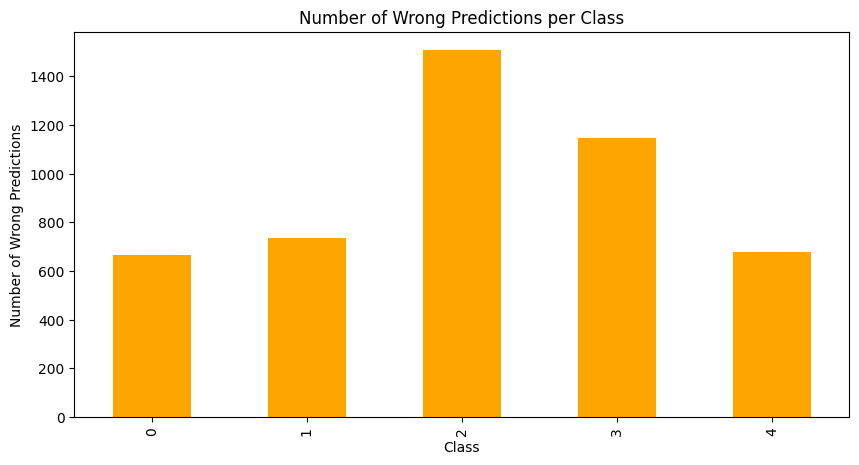

In [111]:
# Count wrong predictions per class
wrong_per_class = pd.Series([test_label_encoded[idx] for idx in wrong_predictions_indices]).value_counts()

# Plot wrong predictions per class
plt.figure(figsize=(10, 5))
wrong_per_class.sort_index().plot(kind='bar', color='orange')
plt.xlabel('Class')
plt.ylabel('Number of Wrong Predictions')
plt.title('Number of Wrong Predictions per Class')
plt.savefig("distribution_wrong_prediction.png")

### Visualise of wrong predictions on Class Basis

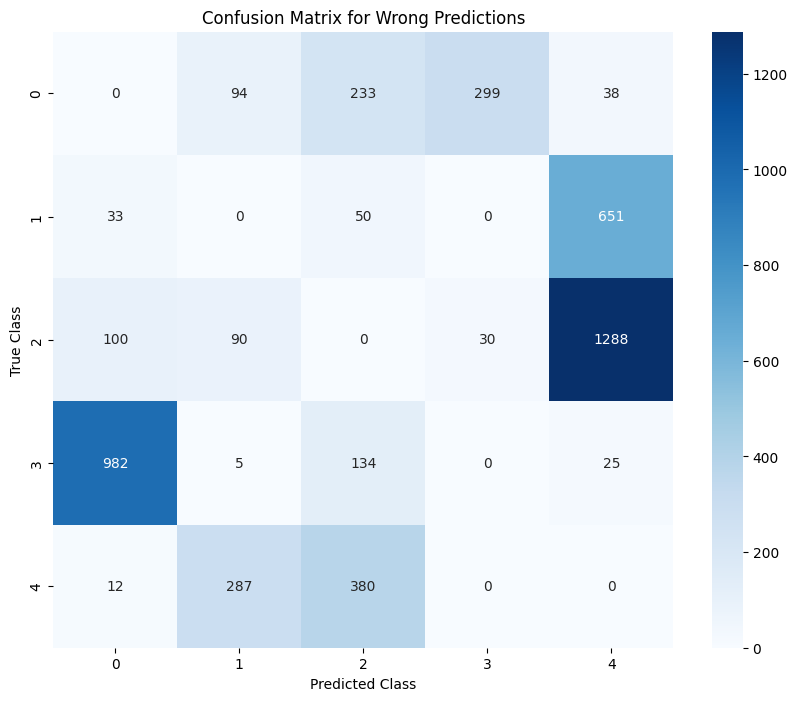

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create a confusion matrix for wrong predictions only
conf_matrix = confusion_matrix(
    wrong_predictions_df['true_label'],
    wrong_predictions_df['predicted_label']
)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.title("Confusion Matrix for Wrong Predictions")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.savefig("confusion_matrix_wrong_prediction.png")

### 2. Confidence Distribution for Wrong Predictions:
This shows how confident the model was for its wrong predictions.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


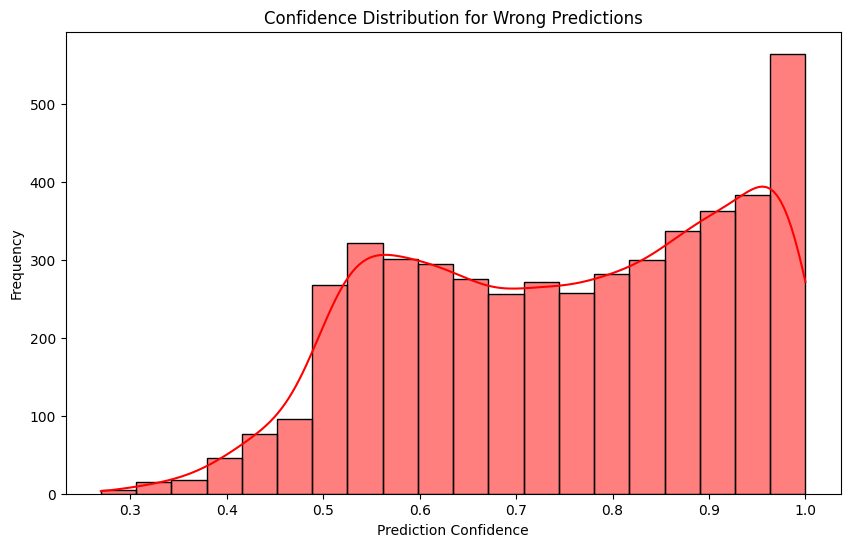

In [113]:
# Plot the distribution of confidence scores for wrong predictions
plt.figure(figsize=(10, 6))
sns.histplot(wrong_predictions_df['probability'], bins=20, kde=True, color="red")
plt.title("Confidence Distribution for Wrong Predictions")
plt.xlabel("Prediction Confidence")
plt.ylabel("Frequency")
plt.savefig("confidence_distribution_wrong_predictions.png",format='png')

### Confusion matrix for whole test dataset

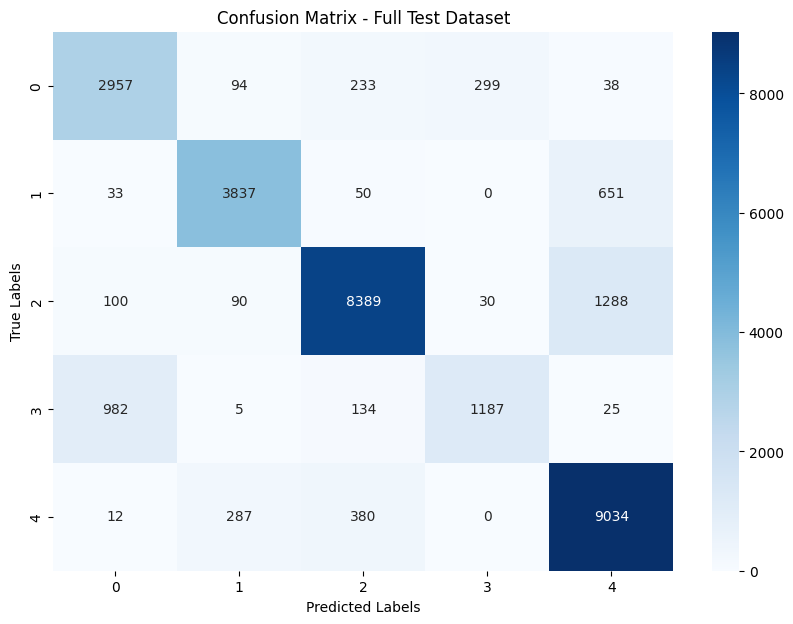

In [114]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(test_label_encoded, test_preds)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(conf_matrix.shape[1]), yticklabels=np.arange(conf_matrix.shape[0]))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Full Test Dataset')
plt.savefig("confusion_matrix_full_test.png",format='png')